In [1]:
import pandas as pd
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
filename = "sap_storing_data_hu_project.csv" 
df_not_cleaned = pd.read_csv(filename, low_memory=False)
#verwijder alle kolommen die niet van gebruik zijn:
df = df_not_cleaned.drop(columns=['stm_sap_mon_meld_ddt', 'stm_mon_begin_ddt', 'stm_mon_toelichting_trdl', 'stm_oh_pg_mld', 'stm_geo_mld_uit_functiepl', 'stm_scenario_mon', 'stm_status_melding_sap', 'stm_mon_nr_status_omschr', 'stm_mon_nr__statuscode', 'stm_mon_nr_status_wijzdd', 'stm_aanntpl_ddt', 'stm_geo_gst_uit_functiepl', 'stm_objectdl_code_gst', 'stm_objectdl_groep_gst', 'stm_progfh_in_ddt', 'stm_progfh_in_invoer_ddt', 'stm_progfh_gw_ddt', 'stm_progfh_gw_lwd_ddt', 'stm_progfh_hz', 'stm_veroorz_groep', 'stm_veroorz_code', 'stm_progfh_gw_duur', 'stm_progfh_gw_lwd_tijd', 'stm_progfh_gw_lwd_datum', 'stm_progfh_gw_datum', 'stm_arbeid', 'stm_functiepl_gst', 'stm_functiepl_mld', 'stm_mon_begintijd', 'stm_mon_begindatum', 'stm_aangelegd_tijd', 'stm_aangelegd_dd', 'stm_dir_betrok_tr', 'stm_evb', 'stm_mon_vhdsincident', 'stm_mon_eind_ddt', 'stm_afspr_aanvangddt', 'stm_effect', 'stm_veroorz_tekst_kort', 'stm_projnr', 'stm_wbi_nummer', 'stm_status_gebr', 'stm_standplaats', 'stm_actie', 'stm_hinderwaarde', 'stm_rec_toegev_ddt', 'stm_afsluit_tijd', 'stm_afsluit_dd', 'stm_afsluit_ddt', 'stm_akkoord_melding_jn', 'stm_fact_jn', 'stm_status_sapnaarmon', 'stm_akkoord_mon_toewijz', 'stm_controle_dd', 'stm_mon_eind_tijd', 'stm_mon_eind_datum', 'stm_reactie_duur', 'stm_afspr_aanvangtijd', 'stm_afspr_aanvangdd', 'stm_historie_toelichting', 'stm_schade_verhaalb_jn', 'stm_x_bron_arch_dt', 'stm_x_bron_bestandsnaam', 'stm_x_bron_publ_dt', 'stm_rapportage_jaar', 'stm_rapportage_maand', 'stm_sorteerveld', 'stm_afspr_func_hersteltijd', 'stm_afspr_func_hersteldd', 'stm_relatiervo', 'stm_relatiervo_volgend', 'stm_relatiervo_vorig', 'stm_schade_statusdatum', 'stm_schade_status_ga', 'stm_schadenr', 'stm_x_start_sessie_dt', 'stm_x_bk', 'stm_x_run_id', 'stm_x_actueel_ind', 'stm_x_vervallen_ind'])
print("Done")

Done


In [3]:
#deze functie verwijdert alle rijen waar geen value op de gegeven kolommen zitten
def drop_rows_with_null(lst, df):
    dfisnull = df.isnull()[lst]
    matches = dfisnull[(dfisnull).any(axis=1)]
    return df.drop(matches.index)

In [4]:
df_filtered = drop_rows_with_null(['stm_geo_mld', 'stm_sap_melddatum', 'stm_oorz_code', 'stm_sap_meldtijd',
                          'stm_fh_dd', 'stm_fh_tijd','stm_oorz_groep',
                          'stm_fh_duur'], df)

In [5]:
df_filtered.drop_duplicates(subset ="#stm_sap_meldnr", 
                     keep = False, inplace = True)

In [6]:
df_filtered['stm_sap_meld_ddt'] = df_filtered['stm_sap_meld_ddt'].apply(pd.to_datetime) # maakt het type: datetime

In [7]:
df_year = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.year)
df_filtered.insert(5, 'Jaar', df_year) # zet het jaar los in de tabel

In [8]:
df_day = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.dayofyear)
df_filtered.insert(6, 'Dag_van_jaar', df_day) # zet de dag count van het jaar los in de tabel (1-365)

In [9]:
df_hour = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.hour)
df_filtered.insert(7, 'Uur_van_dag', df_hour) # zet het uur van de dag los in de tabel (0-23)

In [10]:
df_min = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.minute)
df_filtered.insert(8, 'Minuut_van_uur', df_min) # zet de minuten van het uur los in de tabel (0-59)

In [11]:
df_hour_min = (df_filtered['Uur_van_dag'] * 60) + df_filtered['Minuut_van_uur']
df_filtered.insert(9, 'Minuut_van_dag', df_hour_min) # zet de minuut van de dag in een tabel (0-1440)

In [12]:
df_filtered = (df_filtered.loc[(df_filtered['stm_fh_duur'] > 5) & (df_filtered['stm_fh_duur'] < 360)])

In [13]:
# minuut van de dag dat de aannemer ter plekken is gekomen lijst gemaakt en in dataset gezet.
df_filtered['stm_aanntpl_tijd'] = df_filtered['stm_aanntpl_tijd'].apply(pd.to_datetime)
df_hour = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.hour)
df_filtered.insert(0, 'Uur_herstel', df_hour)
df_min = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.minute)
df_filtered.insert(1, 'Min_van_uur_herstel', df_min)
df_min_of_day_herstel = (df_filtered['Uur_herstel'] * 60) + df_filtered['Min_van_uur_herstel']
df_filtered.insert(2, 'Minuut_van_dag_herstel', df_min_of_day_herstel)
# Eigenlijk precies hetzelfde als hier boven maar dan in 1 cel

In [14]:
# minuut van de dag dat de aannemer klaar is lijst gemaakt en in dataset gezet.
df_filtered['stm_fh_ddt'] = df_filtered['stm_fh_ddt'].apply(pd.to_datetime)
df_hour2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.hour)
df_filtered.insert(3, 'Uur_hersteld', df_hour2)
df_min2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.minute)
df_filtered.insert(4, 'Min_van_uur_hersteld', df_min2)
df_min_of_day_herstel2 = (df_filtered['Uur_hersteld'] * 60) + df_filtered['Min_van_uur_hersteld']
df_filtered.insert(5, 'Minuut_van_dag_hersteld', df_min_of_day_herstel2)
# Eigenlijk precies hetzelfde als hier boven maar dan in 1 cel

In [15]:
Echte_herstel_tijd = df_filtered['Minuut_van_dag_hersteld'] - df_filtered['Minuut_van_dag_herstel']
df_filtered.insert(6, 'Echte_hersteltijd', Echte_herstel_tijd)
# berekent het verschil tussen de minuten van de dag (dus het berekent eigenlijk de reparatie tijd, 
# van aankomst aannemer tot gefixt)

In [16]:
# hoger dan 5 minuten,als het onder de 5 minuten zit is er een goede kans dat het een fout was.
#onder de 360 min (6 uur) de productowner had dit als waarde aan ons gegeven. 
df_filtered = (df_filtered.loc[(df_filtered['Echte_hersteltijd'] > 5) & (df_filtered['Echte_hersteltijd'] < 360)])
df_filtered # dit is de data set na alle filtering. 173749 van de 898526 zijn overgebleven

,Uur_herstel,Min_van_uur_herstel,Minuut_van_dag_herstel,Uur_hersteld,Min_van_uur_hersteld,Minuut_van_dag_hersteld,Echte_hersteltijd,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,...,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar
31,0,0,0,1.0,2.0,62.0,62.0,31,50053257,0.0,...,05/01/2006,01:02:00,29.0,05/01/2006,01:02:00,Suicidaal persoon langs het spoor.,NaN,NaN,NaN,NaN
44,0,0,0,0.0,40.0,40.0,40.0,44,50053290,0.0,...,07/01/2006,00:40:00,10.0,07/01/2006,00:40:00,Mcn meldt suicidaal persoon thv station.,NaN,NaN,NaN,NaN
45,0,0,0,3.0,34.0,214.0,214.0,45,50053292,0.0,...,08/01/2006,03:34:00,14.0,08/01/2006,03:34:00,op overweg 22.9 zijn fietsen neergelegd>,NaN,NaN,NaN,NaN
65,0,0,0,0.0,49.0,49.0,49.0,67,50053366,1.0,...,10/01/2006,00:49:00,48.0,10/01/2006,00:49:00,ree,NaN,NaN,Dv,Apda
101,0,0,0,5.0,50.0,350.0,350.0,103,50053412,7.0,...,12/01/2006,05:50:00,20.0,12/01/2006,05:50:00,Rijp op bovenleiding,NaN,NaN,Hde,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898274,8,17,497,11.0,52.0,712.0,215.0,908378,99003150,0.0,...,02/09/2012,11:52:00,256.0,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN
898275,11,20,680,11.0,54.0,714.0,34.0,908379,99003151,0.0,...,02/09/2012,11:54:00,79.0,02/09/2012,11:54:00,NaN,NaN,NaN,NaN,NaN
898277,13,1,781,13.0,21.0,801.0,20.0,908381,99003153,0.0,...,02/09/2012,13:21:00,58.0,02/09/2012,13:22:00,NaN,NaN,NaN,NaN,NaN
898322,15,13,913,15.0,42.0,942.0,29.0,908426,99003175,0.0,...,19/10/2013,15:42:00,139.0,19/10/2013,15:43:00,NaN,NaN,NaN,NaN,19/10/2013


# Baseline
Target variabele is 'stm_fh_duur'. Dit is de functie hersteltijd dit houd in dat vanaf de melding tot dat het probleem opgelost is getimed wordt. 

baseline:  

In [40]:
data_fht = df_filtered['Echte_hersteltijd'].loc[(df_filtered['Echte_hersteltijd'] > 5) & (df_filtered['Echte_hersteltijd'] < 360)]
data_fht

31         62.0
44         40.0
45        214.0
65         49.0
101       350.0
          ...  
898274    215.0
898275     34.0
898277     20.0
898322     29.0
898422    282.0
Name: Echte_hersteltijd, Length: 173749, dtype: float64

In [19]:
data_fht.mean()

57.258389976345185

In [20]:
data_fht.median()

38.0

<AxesSubplot:>

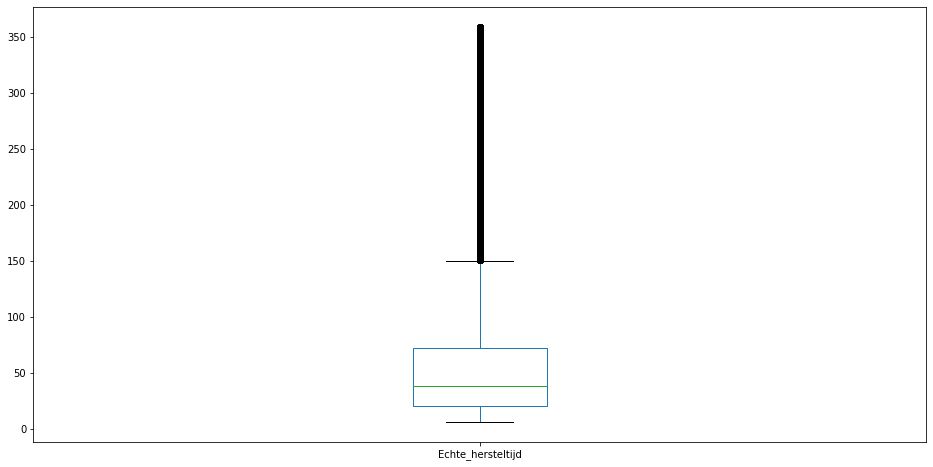

In [21]:
data_fht.plot.box(figsize=(16,8))

In [41]:
len(data_fht[data_fht < data_fht.mean()])/len(data_fht)*100

66.20066878082753

In [42]:
len(data_fht[data_fht < data_fht.median()])/len(data_fht)*100

49.83107816447864

66.2% van alle herstel tijden zit onder het gemiddelde (102 min)

49.8% van alle herstel tijden zit onder de mediaan (82 min)

In [24]:
data_fht = data_fht.to_frame()
#data_fht['mediaan'] = data_fht['stm_fh_duur'].median()
data_fht['mediaan'] = data_fht['Echte_hersteltijd'].median()
#data_fht['mean'] = data_fht['stm_fh_duur'].mean()
data_fht['mean'] = data_fht['Echte_hersteltijd'].mean()
data_fht.head()

,Echte_hersteltijd,mediaan,mean
31,62.0,38.0,57.25839
44,40.0,38.0,57.25839
45,214.0,38.0,57.25839
65,49.0,38.0,57.25839
101,350.0,38.0,57.25839


In [25]:
#de score bepalen aan de hand van de RSME
#np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mediaan']))
np.sqrt(mean_squared_error(data_fht.loc[:,'Echte_hersteltijd'],data_fht.loc[:,'mediaan']))

60.13556733915997

# linear regression

In [26]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']]
y= df_filtered[['Echte_hersteltijd']]

In [27]:
# de data splitsen in training en testing data
from sklearn.model_selection import train_test_split
# test_size
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=0) 

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
linear_reg_model = LinearRegression()

In [30]:
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [31]:
from sklearn.metrics import mean_squared_error

y_pred_test = linear_reg_model.predict(X_test)

error_metric = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric)

56.71417117303172


In [32]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']]
y= df_filtered[['Echte_hersteltijd']]

Text(0.5, 1.0, 'voorspelling tegen over daadwerkelijke data')

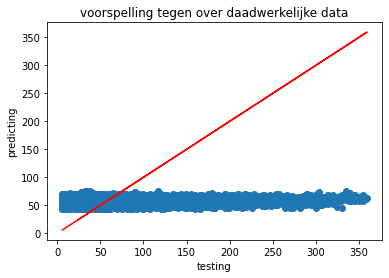

In [33]:
# model plotten en lineare regressie er in verwerken
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_test)
ax.plot(y_test, y_test, color='red')
ax.set_xlabel('testing')
ax.set_ylabel('predicting')
ax.set_title('voorspelling tegen over daadwerkelijke data')

In [34]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',40),
    ('stm_prioriteit',6),
    ('Dag_van_jaar',100),
    ('Jaar',2020),
    ('Minuut_van_dag', 420)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

str(linear_reg_model.predict(new_data))

'[[63.55698693]]'

# Validatie

In [35]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',49482),
    ('stm_prioriteit',2),
    ('Dag_van_jaar',145),
    ('Jaar',2017),
    ('Minuut_van_dag', 1025)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

str(linear_reg_model.predict(new_data))

'[[49.92862375]]'

In [36]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',78781),
    ('stm_prioriteit',2),
    ('Dag_van_jaar',145),
    ('Jaar',2018),
    ('Minuut_van_dag', 817)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

str(linear_reg_model.predict(new_data))

'[[53.28005973]]'

In [37]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',0),
    ('stm_prioriteit',1),
    ('Dag_van_jaar',11),
    ('Jaar',2018),
    ('Minuut_van_dag', 1020)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

str(linear_reg_model.predict(new_data))

'[[48.78279187]]'

# Applicatie
Als je de onderstaande code wilt runnen, zorg dan dat de meegeleverde afbeeldingen in dezelfde map staan en de bovenstaande code gerund is.

In [39]:
"""
from tkinter import *
from datetime import datetime
import random
import pandas as pd
import numpy as np
from collections import OrderedDict
from sklearn.model_selection import train_test_split


def showcontents1():
    historyframe.pack_forget()
    screenframe.pack_forget()
    entryframe.pack_forget()
    screenframe.pack(side=LEFT, padx=150)
    mylist.delete(0, END)
    file = open("example.txt", "r")
    lines = file.readlines()
    for i in reversed(lines):
        mylist.insert(END, i)

    text.pack(side=TOP)
    mylist.pack(side=TOP)

    file.close()


def showentryframe():
    screenframe.pack_forget()
    historyframe.pack_forget()
    entryframe.pack_forget()
    texterror.grid_forget()

    entry.delete('1.0', 'end')
    entry2.delete('1.0', 'end')
    entry3.delete('1.0', 'end')

    entryframe.pack(side=LEFT, padx=150)
    textentry.grid(row=0, column=0, sticky=W + E + N + S, pady=5)
    textentry2.grid(row=1, column=0, sticky=W + E + N + S, pady=5)
    textentry3.grid(row=2, column=0, sticky=W + E + N + S, pady=5)

    entry.grid(row=0, column=1, sticky=W + E + N + S, pady=5)
    entry2.grid(row=1, column=1, sticky=W + E + N + S, pady=5)
    entry3.grid(row=2, column=1, sticky=W + E + N + S, pady=5)
    enterbutton.grid(row=3, column=0)


def home():
    screenframe.pack_forget()
    entryframe.pack_forget()
    historyframe.pack_forget()    


def enterdata():
    Datum_tijd = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    location = str(entry.get("1.0", END)).split('\n')[0]
    prioriteit = str(entry2.get("1.0", END)).split('\n')[0]
    km_afstand = str(entry3.get("1.0", END)).split('\n')[0]
    
    Datum_tijd2 = datetime.now().strftime("%m/%d/%Y, %H:%M:%S") , '2012-11-14 14:32:30' # er moeten minimaal 2 inzitten daarom een random maar ingevuld
    datum_Dataset = pd.DataFrame(Datum_tijd2, columns=['dates'])
    datum_Dataset['dates'] = datum_Dataset['dates'].apply(pd.to_datetime)
    df_jaar = pd.DataFrame(datum_Dataset['dates'].dt.year)
    datum_Dataset.insert(1, 'Jaar', df_jaar) # zet het jaar los in de tabel
    df_day = pd.DataFrame(datum_Dataset['dates'].dt.dayofyear)
    datum_Dataset.insert(2, 'Dag_van_jaar', df_day) # zet de dag count van het jaar los in de tabel (1-365)
    df_hour = pd.DataFrame(datum_Dataset['dates'].dt.hour)
    datum_Dataset.insert(3, 'Uur_van_dag', df_hour) # zet het uur van de dag los in de tabel (0-23)
    df_min = pd.DataFrame(datum_Dataset['dates'].dt.minute)
    datum_Dataset.insert(4, 'Minuut_van_uur', df_min) # zet de minuten van het uur los in de tabel (0-59)
    df_hour_min = (datum_Dataset['Uur_van_dag'] * 60) + datum_Dataset['Minuut_van_uur']
    datum_Dataset.insert(5, 'Minuut_van_dag', df_hour_min) # zet de minuut van de dag in een tabel (0-1440)

    jaar = datum_Dataset['Jaar'][0]
    dag_van_jaar = datum_Dataset['Dag_van_jaar'][0]
    min_dag = datum_Dataset['Minuut_van_dag'][0]
    
    new_data = OrderedDict([
    ('stm_km_van_mld',km_afstand),
    ('stm_prioriteit',prioriteit),
    ('Dag_van_jaar',dag_van_jaar),
    ('Jaar',int(jaar)),
    ('Minuut_van_dag', min_dag)
    ])
    new_data = pd.Series(new_data).values.reshape(1,-1)
    repairtime = str(linear_reg_model.predict(new_data))

    if type == "" or location == "" or km_afstand == "":
        texterror.grid(row=3, column=1, sticky=W + E + N + S, pady=5)
    else:
        file = open('example.txt', 'a')
        file.write(location + " | " + Datum_tijd + " | " + repairtime + "\n")
        file.close()
        showentryframe()
        

root = Tk()

#startscreen
loginframe = Frame(master=root)
loginframe.pack(fill="both", expand=True)
background_image=PhotoImage(file="hoofdmenu.png")
background_label = Label(image=background_image, master=loginframe)
background_label.place(x=0, y=0, relwidth=1, relheight=1)

buttonsframe = Frame(loginframe)
buttonsframe.pack(side=LEFT, padx=50)

#screen button 2
screenframe = Frame(loginframe)
mylist = Listbox(master=screenframe, font=('verdana', 20, 'bold'), width=60, height=20, bg='#ee5943', fg='black')
text = Text(screenframe, font=('verdana', 20, 'bold'),  width=60, height=1, bg='#e34114', fg='black')
text.insert(END, "Location/Train route     |     Created at     |     Estimated repairtime")

#screen button 3
historyframe = Frame(loginframe)
mylist_history = Listbox(master=historyframe, font=('verdana', 15, 'bold'), width=80, height=25, bg='#ee5943', fg='black')
text_history = Text(historyframe, font=('verdana', 20, 'bold'),  width=60, height=1, bg='#e34114', fg='black')
text_history.insert(END, "Location/Train route | Created at | Finished at| Repairtime")

#screen button 4
entryframe = Frame(loginframe, bg='#c41b0c')
entry = Text(master=entryframe,relief='flat',bd=2,font=('verdana', 20, 'bold'),height=0,fg='black',bg='#FFFFFF', width=70)
entry2 = Text(master=entryframe,relief='flat',bd=2,font=('verdana', 20, 'bold'),height=0,fg='black',bg='#FFFFFF', width=70)
entry3 = Text(master=entryframe,relief='flat',bd=2,font=('verdana', 20, 'bold'),height=0,fg='black',bg='#FFFFFF', width=70)

textentry = Text(entryframe, font=('verdana', 20, 'bold'),  width=5, height=1, bg='#ee5943', bd=0)
textentry2 = Text(entryframe, font=('verdana', 20, 'bold'),  width=8, height=1, bg='#ee5943', bd=0)
textentry3 = Text(entryframe, font=('verdana', 20, 'bold'),  width=11, height=1, bg='#ee5943', bd=0)

textentry.insert(END, "Location") 
textentry2.insert(END, "Prioriteit")
textentry3.insert(END, "KM afstand")


enterbutton = Button(master=entryframe, text='Enter',command=enterdata,bg='#e32514', fg='white',relief=FLAT, font=('verdana',20,'bold'),cursor='circle')
texterror = Text(entryframe, font=('verdana', 20, 'bold'),  width=60, height=1, bg='#c41b0c', bd=0)
texterror.insert(END, "Not all boxes filled")

#button 1
img1 = PhotoImage(file="prorailbutton.png") # make sure to add "/" not "\"
how = Button(master=buttonsframe, command=home, relief=FLAT,cursor='circle')
how.config(bg='#ef5b44', image=img1)
how.pack(anchor='nw')

label5 = Label(master=loginframe, text='{:^200}'.format('-----------------------------------'),
               bg='#850800', fg='white', font=('verdana', 30, 'bold'))

#button 2
img2 = PhotoImage(file="currentbutton.png") # make sure to add "/" not "\"
how = Button(master=buttonsframe, command=showcontents1,relief=FLAT,cursor='circle')
how.config(bg='#ef5b44', image=img2)
how.pack(anchor='nw')


#button 4
img4 = PhotoImage(file="newbutton.png") # make sure to add "/" not "\"
how = Button(master=buttonsframe, command=showentryframe, relief=FLAT, cursor='circle')
how.config(bg='#ef5b44', image=img4)
how.pack(anchor='nw')


root.mainloop()
"""